# Descriptive Text Mining

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

Obiettivo: dai rapporti medici relativi al dataset *Adverse drug events* (ADE) individuare, mediante analisi semantica con LSA, le cause che contribuiscono a provocare eventi dannosi per i pazienti.

In [39]:
import sys
IN_COLAB = 'google.colab' in sys.modules
base_url = "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/data/"

In [ ]:
!{sys.executable} -m pip install scispacy==0.4.0

In [ ]:
!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

## Librerie impiegate

In [6]:
from os import path, makedirs
from tabulate import tabulate
from urllib.request import urlretrieve
import numpy as np
from numpy.linalg import norm
import pandas as pd
import spacy
import scispacy
import pickle
from operator import itemgetter

from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors
import plotly.graph_objects as go
import plotly.express as px

import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.stats import chi2_contingency

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
images_path = "./"
makedirs(images_path, exist_ok = True)
get_path = lambda fname, format : path.join(images_path, fname + "." + format)
savefig = lambda fname, format : plt.savefig(get_path(fname, format), format = format)

## Funzioni impiegate

In [8]:
def makequery(qterms, tdm, U, s, vocabulary):
    query = np.zeros(tdm.shape[0])

    # one hot query
    query[[vocabulary.get(term) for term in qterms]] = 1
    # weighted query
    wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
    # folded query
    qls = np.matmul(wquery.T, U)

    # cosine similary query term
    dk = np.matmul(qls, np.diag(np.power(s, -1)))
    dksrs = np.matmul(dk, np.diag(np.sqrt(s)))

    return qterms, query, wquery, qls, dk, dksrs

In [9]:
def get_matching_docs(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.isin(a, b).sum()

In [10]:
def entropy(m, axis = 0):
    m = np.asarray(m)
    p = 1.0 * m / np.sum(m, axis = axis, keepdims = True)
    ndocs = m.shape[axis]
    vec = (p * np.log(p, out = np.zeros_like(p), where = (p!=0))) / np.log(ndocs)
    entropy = - np.sum(vec, axis = axis)
    return entropy

In [11]:
def get_word_counts(m, col_mask, row_mask):
    # get only doc_class related docs
    sliced = tdm[:, col_mask]
    
    # slice rows, get only columns with at least one of 
    # the entries in the row mask.
    sliced = sliced[row_mask, :]
    
    with_word = get_occ_word_all_docs(sliced)
    total = col_mask.sum()
    without_word = total - with_word
    return with_word, without_word

def get_occ_word_all_docs(sliced):
    # logical AND applied to all rows, one for each term
    # in the list.
    rows = [row for row in sliced]
    tmp = np.asarray(sliced[0])
    for row in rows:
        b = np.logical_and(tmp, row)
        tmp = b
    b = np.asarray(b)[0]
    return b.sum()

In [12]:
def term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out,
    quiet=False):  
    
    get_term_doc_df = \
        lambda data, terms, doc_classes : pd.DataFrame(
            data,
            index = [f"not {terms}", f"{terms}"], 
            columns = [f"not {doc_classes}", f"{doc_classes}"]
        )   
    
    terms = "_".join(terms)
    doc_classes = "_".join(doc_classes)
    
    observed = [
        [without_word_out, without_word_in],
        [with_word_out, with_word_in]
    ]
    observed = get_term_doc_df(observed, terms, doc_classes)

    chi2, p, ddof, expected = chi2_contingency(
        observed,
        correction = False
    )
    expected = get_term_doc_df(expected, terms, doc_classes)
    
    if quiet is False:
        print(f"Pearson's Chi-squared test with {ddof} ddof")
        print("--------------------------------------\n")
        print("Observed frequencies") 
        print(tabulate(observed, headers='keys', tablefmt='psql'))
        print("\nExpected frequencies")
        print(tabulate(expected, headers='keys', tablefmt='psql'))
        print(f"\nX-squared: \t{chi2}")
        print(f"p-value \t{p}")
    
    return chi2, p

In [13]:
def get_similar(m, q, docs, threshold = 0, topn = 10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    docs = np.asarray(docs)
    docs = docs.reshape(docs.shape[0], 1)
    q = np.asarray(q)
    q = q.reshape(1, m.shape[1])
    query2doc = cosine_similarity(q, m)
    query2doc = query2doc.T
    
    mask = query2doc > threshold
    query2doc_masked = query2doc[mask]
    docs_masked = docs[mask]

    docs_idx = [idx for idx, elem in enumerate(mask) if elem == 1]

    # use a structured array
    dtype = [("id", int), ("doc", docs.dtype), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(query2doc_masked, docs_masked, docs_idx)]
    ranks = np.array(ranks, dtype = dtype)
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # docs in decreasing order
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
    return list(ranks)

In [14]:
def plot_lsa2D(x, y, terms=None):
    fig = go.Figure()

    if terms is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode="markers+text",
            name="Markers and Text")
    else:
        trace = go.Scatter(
                    x=x,
                    y=y,
                    mode="markers+text",
                    name="Markers and Text",
                    text=terms,

                    textposition="bottom center",
                    textfont=dict(
                        family="sans serif",
                        size=9))

    fig.add_trace(trace)
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    return fig

In [15]:
def plot_knee_points(s):
    xlen = 20
    fordiff = lambda x : x[1:len(x)] - x[0:(len(x) - 1)]
    skd = fordiff(s)
    skdd = fordiff(skd)
    skcurv = skdd[0:xlen] / np.power(1 + np.power(skd[0:xlen], 2), 1.5)
    
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(1, xlen, xlen), skcurv, "k.-")
    return plt

In [16]:
def plot_lsa2D_termdoc(
    classes,
    d1,
    d2,
    t1,
    t2,
    ord_terms):
    
    dfc = pd.DataFrame(
        {"Incident" : classes,
         "lsa1" : d1,
         "lsa2" : d2}
    )

    fig = plot_lsa2D(t1, t2, ord_terms)

    fig1 = px.scatter(
        dfc,
        x = "lsa1",
        y = "lsa2",
        color="Incident",
        color_discrete_map=
        {"Not related": "lightgrey",
         "Related": "black"},
        template = "none",
        height = 800
    )

    fig.update_traces(name = "Termini", marker_color="blue")
    fig = go.Figure(data = fig1.data + fig.data)
    fig.update_traces(marker=dict(size=3,))
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    
    return fig

In [17]:
def chisquare_lsa(
    qclasses,
    qterms,
    query_matching_idxs,
    classes,
    dls_rows,
    quiet=False):
    
    doc_classes = ["Negative"]
    terms = ["roma", "gemelli"]
    destroyed_idx = np.asarray(classes == qclasses[0])
    doc_mask = destroyed_idx != 0

    query_mask = np.zeros(dls_rows)
    query_mask[query_matching_idxs] = 1

    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_in = mask.sum()
    without_word_in = total - with_word_in

    doc_mask = ~doc_mask
    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_out = mask.sum()
    without_word_out = total - with_word_out

    return term_analysis(
        qterms,
        qclasses,
        without_word_in,
        with_word_in,
        without_word_out,
        with_word_out,
        quiet=quiet
    )

In [18]:
def get_query_result(
    docs,
    ord_terms,
    dls,
    tls,
    qls,
    tlsn,
    r=482,
    low=0.2,
    high=0.85):
    
    # get matching docs
    docs_ranked = get_similar(
        dls,
        qls,
        docs,
        threshold = low,
        topn = r
    )
    
    # get matching terms
    terms_ranked = get_similar(
        tls[:,0:6],
        qls[0:6],
        ord_terms,
        threshold = low,
        topn = r
    )
    terms_ranked = [rank for rank in terms_ranked if rank[2] > high]
    sim_scores_reduced_idx = [rank[0] for rank in terms_ranked]
    norms = tlsn[sim_scores_reduced_idx]
    
    return docs_ranked, terms_ranked, norms

In [19]:
def get_ord_terms(vocabulary):
    return np.asarray(
        [t for t, i in sorted(vocabulary.items(), key=itemgetter(1))],
        dtype=object,
    )

## Principali medicinali ed effetti collaterali

In [42]:
dataset_name = "ade_corpus.csv"
dataset_url = base_url + dataset_name

if IN_COLAB:
    data_path = "./"
else:
    # plt.style.use('science')
    data_path = "../data/"

if not path.exists(data_path + dataset_name):
    urlretrieve(dataset_url, dataset_name)

df = pd.read_csv(
        data_path + dataset_name, 
        dtype={"text" : "string", "drug" : "category", "effect" : "category"}
)  

In [43]:
df

text  ...                     effect
0         Intravenous azithromycin-induced ototoxicity.  ...                ototoxicity
1     Immobilization, while Paget's bone disease was...  ...  increased calcium-release
2     Unaccountable severe hypercalcemia in a patien...  ...              hypercalcemia
3     METHODS: We report two cases of pseudoporphyri...  ...            pseudoporphyria
4     METHODS: We report two cases of pseudoporphyri...  ...            pseudoporphyria
...                                                 ...  ...                        ...
6816  Lithium treatment was terminated in 1975 becau...  ...       lithium intoxication
6817  Lithium treatment was terminated in 1975 becau...  ...       lithium intoxication
6818  Eosinophilia caused by clozapine was observed ...  ...               Eosinophilia
6819  Eosinophilia has been encountered from 0.2 to ...  ...               Eosinophilia
6820  Successful challenge with clozapine in a histo...  ...               eosinophilia

[6821 rows x 3 columns]

Medicinali

> Names of drugs and chemicals that include brand names, trivial names, abbreviations and systematic names were annotated. Mentions of drugs or chemicals should strictly be in a therapeutic context. This category does not include the names of metabolites, reaction byproducts, or hospital chemicals (e.g. surgical equipment disinfectants).

In [44]:
df.drug.value_counts()

methotrexate               151
lithium                     92
amiodarone                  74
carbamazepine               69
MTX                         65
                          ... 
aminophylline                1
alpha-interferon             1
alpha-2b peginterferon       1
all-trans-retinoic acid      1
 minocycline                 1
Name: drug, Length: 1319, dtype: int64

Effetti collaterali

> Mentions of adverse effects include signs, symptoms, diseases, disorders, acquired abnormalities, deficiencies, organ damage or death that strictly occur as a consequence of drug intake.

In [45]:
df.effect.value_counts()

fever                                         61
thrombocytopenia                              56
neurotoxicity                                 54
rhabdomyolysis                                44
seizures                                      42
                                              ..
hypersensitivity rash                          1
hypersensitivity pneumonitis-like syndrome     1
hyperproduction of TNF-alpha                   1
hypernatraemia                                 1
"cotton-wool" spots                            1
Name: effect, Length: 3341, dtype: int64

## Caricamento dei dati

In [46]:
dataset_url = \
    "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/data/ade_causes.csv"
dataset_name = "ade_causes.csv"

if IN_COLAB:
    data_path = "./"
else:
    # plt.style.use('science')
    data_path = "../data/"

if not path.exists(data_path + dataset_name):
    urlretrieve(dataset_url, dataset_name)

df = pd.read_csv(
        data_path + dataset_name, 
        dtype={"text" : "string", "label" : "category"}
)  
df.drop_duplicates(subset ="text", keep = False, inplace = True)

In [47]:
df.label = df.label.cat.rename_categories(
    {"1" : "Related",
     "0" : "Not related"}
)

In [48]:
df

text        label
0          Intravenous azithromycin-induced ototoxicity.      Related
1      Immobilization, while Paget's bone disease was...      Related
2      Unaccountable severe hypercalcemia in a patien...      Related
5      Naproxen, the most common offender, has been a...      Related
10     BACKGROUND: How to best treat psychotic patien...      Related
...                                                  ...          ...
23511  At autopsy, the liver was found to be small, s...  Not related
23512  Physical exam revealed a patient with aphasia,...  Not related
23513  At the time when the leukemia appeared seven o...  Not related
23514  The American Society for Regional Anesthesia a...  Not related
23515  Concomitant administration of estradiol result...  Not related

[19464 rows x 2 columns]

In [49]:
ade_class = list(df.label.unique())
fig = go.Figure(
    data = [go.Pie(labels = ade_class,
            values = df.label.value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = "Distribuzione del tipo di rapporti medici")
fig.show()

In [50]:
df

text        label
0          Intravenous azithromycin-induced ototoxicity.      Related
1      Immobilization, while Paget's bone disease was...      Related
2      Unaccountable severe hypercalcemia in a patien...      Related
5      Naproxen, the most common offender, has been a...      Related
10     BACKGROUND: How to best treat psychotic patien...      Related
...                                                  ...          ...
23511  At autopsy, the liver was found to be small, s...  Not related
23512  Physical exam revealed a patient with aphasia,...  Not related
23513  At the time when the leukemia appeared seven o...  Not related
23514  The American Society for Regional Anesthesia a...  Not related
23515  Concomitant administration of estradiol result...  Not related

[19464 rows x 2 columns]

## Caricamento della matrice termini documenti

In [51]:
dataset_name = "tdm_ade.npz"

if not path.exists(data_path + dataset_name):
    dataset_url = base_url + dataset_name
    urlretrieve(dataset_url, dataset_name)

tdm = sp.load_npz(data_path + dataset_name)
tdm = tdm.todense()
b = (1 - entropy(tdm, axis = 1))
b = np.array(b)

a = np.log(tdm + 1)
a = np.array(a)

wtdm = (a.T * b).T
wtdm = sp.csr_matrix(wtdm)

In [52]:
wtdm

<901x19464 sparse matrix of type '<class 'numpy.float64'>'
	with 123411 stored elements in Compressed Sparse Row format>

In [53]:
file_name = 'vocabulary_ade.sav'

if not path.exists(data_path + file_name):
    dataset_url = base_url + file_name
    urlretrieve(dataset_url, file_name)

vocabulary = pickle.load(open(data_path + file_name, 'rb'))

In [54]:
ord_terms = get_ord_terms(vocabulary)

In [55]:
wtdm.astype(bool).mean()

0.007037152855232817

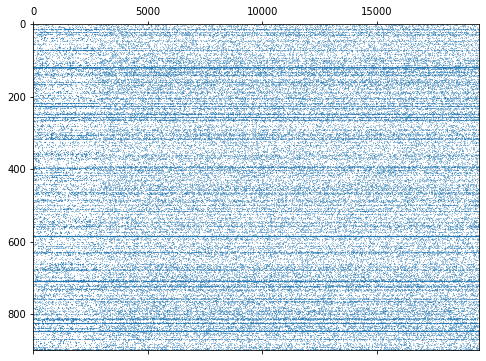

In [56]:
fig = plt.figure()
plt.spy(wtdm, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)

## Analisi semantica latente

In [57]:
k = 150
U, s, Vh = randomized_svd(wtdm, n_components = k, random_state = 5)

In [58]:
s.shape

(150,)

In [59]:
U.shape

(901, 150)

In [60]:
Vh.shape

(150, 19464)

In [61]:
Vh = Vh.transpose()

In [62]:
Vh.shape

(19464, 150)

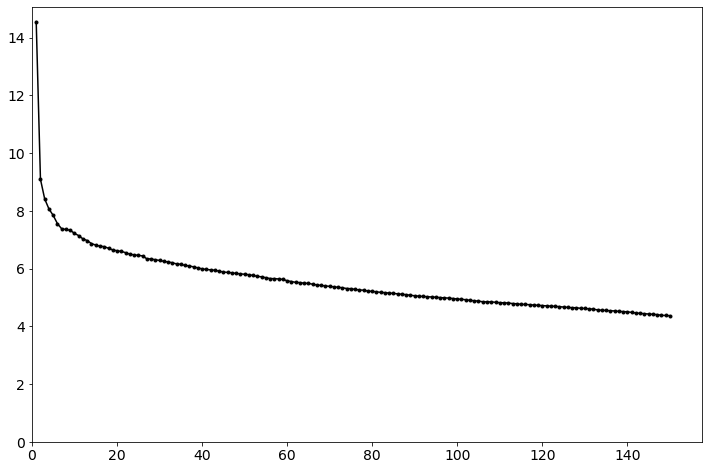

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1, k, k), s, "k.-")
plt.ylim(bottom=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=0)
savefig("power_law_svd_ade", "pdf")

In [64]:
tls = np.matmul(U, np.diag(s))
dls = np.matmul(Vh, np.diag(s))

In [65]:
tls.shape

(901, 150)

In [66]:
dls.shape

(19464, 150)

## Visualizzazione dello spazio trasformato

Visualizzazione dei termini nelle prime due dimensioni latenti

In [67]:
plot_lsa2D(-1*tls[:,0], -1*tls[:,1], ord_terms)

In [68]:
plot_lsa2D(-1*dls[:,0], -1*dls[:,1])

In [69]:
plot_lsa2D(-1*tls[:,1], tls[:,2], ord_terms)

In [70]:
plot_lsa2D(-1*dls[:,1], dls[:,2])

## Distribuzione delle tipologie di rapporti medici

In [71]:
df.label.value_counts()

Not related    16599
Related         2865
Name: label, dtype: int64

In [72]:
dfc = pd.DataFrame(
    {"Report type" : df.label,
     "dls[:,1]" : -1*dls[:,1],
     "dls[:,2]" : dls[:,2]}
)

fig = px.scatter(
    dfc,
    x="dls[:,1]",
    y="dls[:,2]",
    color="Report type",
    color_discrete_map=
    {"Not related": "lightgrey",
     "Related": "black"},
    template="none",
    height=800
)
    
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi termini e documenti

In [73]:
with np.errstate(invalid = "ignore", divide = "ignore"):
    tlsn = norm(tls, 2, axis = 1)
    dlsn = norm(dls, 2, axis = 1)
    tlsn = tls / tlsn[:,None]
    dlsn = dls / dlsn[:,None]

In [74]:
plot_lsa2D_termdoc(
    df["label"],
    -1*dlsn[:,1],
    dlsn[:,2],
    -1*tlsn[:,1],
    tlsn[:,2],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).show()

## Costruzione di un'interrogazione semplice

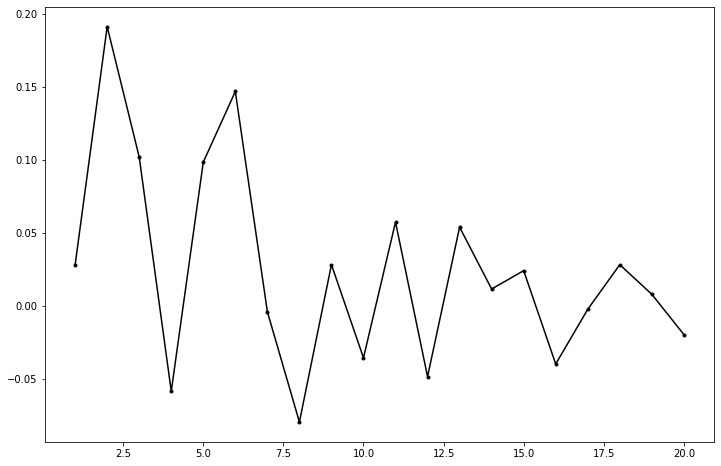

In [75]:
plot_knee_points(s);

In [76]:
knee = 8
qterms = ["acute"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);
qlsn = norm(qls, 2)
qlsn = qls / qlsn

m = dls[:,0:knee]
q = qls[0:knee]
docs = df.text

ranks = get_similar(
    m,
    q,
    docs,
    threshold = 0.2,
    topn = 482
)

query_matching_idxs = [rank[0] for rank in ranks]
sim_scores = [rank[2] for rank in ranks]
[rank[1] for rank in ranks[:10]]

['Flurbiprofen-associated acute tubulointerstitial nephritis.',
 'Ezetimibe-induced acute pancreatitis.',
 'Under the suspicion of amiodarone-induced acute pancreatitis, amiodarone was substituted by propafenone.',
 'Neutropenic enterocolitis and cecal perforation in acute lymphatic leukemia.',
 'Acute myeloid leukaemia with t(8;16)(p11;p13) in a child after intrauterine X-ray exposure.',
 'Grand mal seizures and acute intermittent porphyria.',
 'Pregancy complicated by acute myeloid leukaemia.',
 'All-trans retinoic acid and short-time, high-dose cytarabine in two children with acute promyelocytic leukemia.',
 'Acute interstitial nephritis due to pantoprazole.',
 'Acute amphotericin B overdose.']

In [77]:
query_trace = go.Scatter(
    x = [-1*qlsn[2]],
    y = [qlsn[3]],
    mode = "markers",
    name = "Interrogazione",
    marker = dict(
        size = 12,
        color = "black",
        symbol = "x"
    )
)

plot_lsa2D_termdoc(
    df["label"],
    -1*dlsn[:,2],
    dlsn[:,3],
    -1*tlsn[:,2],
    tlsn[:,3],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).add_trace(query_trace).show()

In [78]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    query_matching_idxs, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-----------+---------------+-----------+
|           |   not Related |   Related |
|-----------+---------------+-----------|
| not acute |         16238 |      2744 |
| acute     |           361 |       121 |
+-----------+---------------+-----------+

Expected frequencies
+-----------+---------------+-----------+
|           |   not Related |   Related |
|-----------+---------------+-----------|
| not acute |     16187.9   | 2794.05   |
| acute     |       411.052 |   70.9479 |
+-----------+---------------+-----------+

X-squared: 	42.45660566105977
p-value 	7.226792731795414e-11


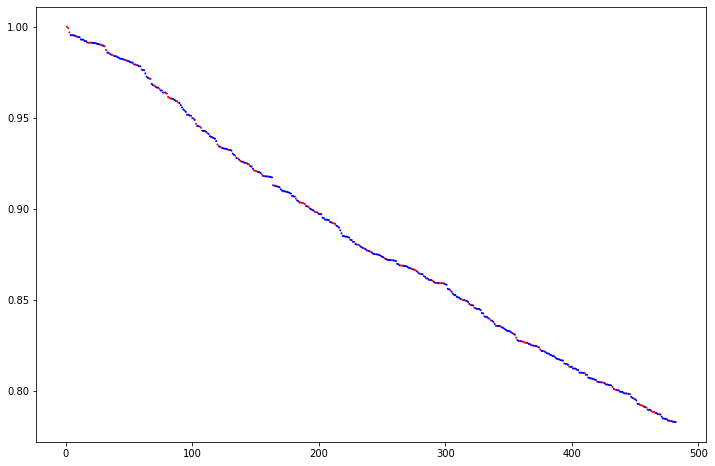

In [79]:
effect_idx = np.asarray(df["label"] == "Related")
effect_entries = np.asarray(
    [1 if effect_idx[idx] == 1 else 0 for idx in query_matching_idxs]
)

plt.figure(figsize=(12, 8))
plt.scatter(
    np.linspace(1, 482, 482),
    sim_scores,
    c = effect_entries,
    marker = "o",
    cmap = "bwr",
    s = 1
)
plt.show()

## Costruzione di un'interrogazione articolata

In [80]:
knee = 8
tlsn = norm(tls[:,0:knee], 2, axis = 1)

### Esempio 1

In [ ]:
["cns",
 "inflammation",
 "vomiting",
 "infection",
 "liver",
 "transplant",
 "bowel",
 "bladder",
 "viral"]

L'intervento di trapianto di fegato può avere delle complicazioni neurologiche, tra cui infezioni virali del sistema nervoso centrale (cns). Il vomito è uno dei possibili sintomi legati a problemi nel sistema nervoso centrale. Altre complicazioni che possono emergere dal trapianto di fegato sono l'infiammazione dell'intestino e l'infezione della vescica. 

In [81]:
docs = df.text
qterms = ["cns", "liver"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked, terms_ranked, norms = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query = [rank[0] for rank in docs_ranked]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked, norms)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9559053337475703, 'central', 2.42059695663733),
 (0.9253385967472361, 'transplant', 1.9241651707425946),
 (0.9746442104396089, 'liver', 1.8846622880138573),
 (0.9596536634267845, 'bowel', 1.6336843877750618),
 (0.9554967989799575, 'bladder', 1.6237868821182615),
 (0.9526222318344715, 'markedly', 1.5335015798154958),
 (0.8773883068770268, 'reverse', 1.4324358355455529),
 (0.9118540794226467, 'transient', 1.363002113222605),
 (0.9075340648288168, 'recognition', 1.053855801058732),
 (0.9404421803264422, 'stem', 0.9187643796637508),
 (0.900942157776413, 'peripheral', 0.5903743242628147),
 (0.9149029484682725, 'contact', 0.5100184961773847),
 (0.9289755623519027, 'spectrum', 0.45824104034068797),
 (0.9243746190539379, 'know', 0.45320476178253905),
 (0.8814341837882369, 'available', 0.4523435174450789),
 (0.866586616101716, 'interval', 0.4192227479987451),
 (0.8640484350762236, 'direct', 0.41007863133909295),
 (0.9019646893768414, 'cytotoxic', 0.3875898349203577),
 (0.9717295699926336, '

In [82]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------+---------------+-----------+
|               |   not Related |   Related |
|---------------+---------------+-----------|
| not cns_liver |         16148 |      2834 |
| cns_liver     |           451 |        31 |
+---------------+---------------+-----------+

Expected frequencies
+---------------+---------------+-----------+
|               |   not Related |   Related |
|---------------+---------------+-----------|
| not cns_liver |     16187.9   | 2794.05   |
| cns_liver     |       411.052 |   70.9479 |
+---------------+---------------+-----------+

X-squared: 	27.04510802413798
p-value 	1.987626019763712e-07


In [83]:
docs = df.text
qterms = ["cns", "liver", "transplant"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked1, terms_ranked1, norms1 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query1 = [rank[0] for rank in docs_ranked1]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked1, norms1)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9470799003066975, 'central', 2.42059695663733),
 (0.9684801013667954, 'transplant', 1.9241651707425946),
 (0.9412979909022193, 'liver', 1.8846622880138573),
 (0.976921607480913, 'bowel', 1.6336843877750618),
 (0.8999202609454447, 'bladder', 1.6237868821182615),
 (0.9771631496400761, 'markedly', 1.5335015798154958),
 (0.9388765566690187, 'transient', 1.363002113222605),
 (0.9285967850548686, 'recognition', 1.053855801058732),
 (0.9689496512868961, 'stem', 0.9187643796637508),
 (0.8640153311183065, 'lower', 0.8384006389161522),
 (0.8808133591243579, 'peripheral', 0.5903743242628147),
 (0.8614806270589179, 'spectrum', 0.45824104034068797),
 (0.9189494084047469, 'know', 0.45320476178253905),
 (0.9310700051677934, 'available', 0.4523435174450789),
 (0.8840839368895372, 'interval', 0.4192227479987451),
 (0.9227428036868698, 'cytotoxic', 0.3875898349203577),
 (0.9762896348697399, 'dopamine', 0.38641967777422825),
 (0.8810523001416932, 'cns', 0.37154351440361844),
 (0.8512916360524484, 'vi

In [84]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query1, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------+---------------+-----------+
|                          |   not Related |   Related |
|--------------------------+---------------+-----------|
| not cns_liver_transplant |         16150 |      2832 |
| cns_liver_transplant     |           449 |        33 |
+--------------------------+---------------+-----------+

Expected frequencies
+--------------------------+---------------+-----------+
|                          |   not Related |   Related |
|--------------------------+---------------+-----------|
| not cns_liver_transplant |     16187.9   | 2794.05   |
| cns_liver_transplant     |       411.052 |   70.9479 |
+--------------------------+---------------+-----------+

X-squared: 	24.404859494389495
p-value 	7.807151300447604e-07


In [85]:
get_matching_docs(docs_matching_query, docs_matching_query1)

388

In [86]:
docs = df.text
qterms = ["cns", "liver", "transplant", "bowel"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked2, terms_ranked2, norms2 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query2 = [rank[0] for rank in docs_ranked2]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked2, norms2)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9515791889544384, 'central', 2.42059695663733),
 (0.9632639737118491, 'transplant', 1.9241651707425946),
 (0.9325362672332106, 'liver', 1.8846622880138573),
 (0.9837723762736773, 'bowel', 1.6336843877750618),
 (0.9045703428143017, 'bladder', 1.6237868821182615),
 (0.984227129994963, 'markedly', 1.5335015798154958),
 (0.9222701038864147, 'transient', 1.363002113222605),
 (0.9079087144960587, 'recognition', 1.053855801058732),
 (0.9717361448147204, 'stem', 0.9187643796637508),
 (0.8584095520786952, 'lower', 0.8384006389161522),
 (0.8854551414511131, 'peripheral', 0.5903743242628147),
 (0.867137514015393, 'spectrum', 0.45824104034068797),
 (0.9037528153054508, 'know', 0.45320476178253905),
 (0.9364540786107749, 'available', 0.4523435174450789),
 (0.8622566425100522, 'interval', 0.4192227479987451),
 (0.9118158657177626, 'cytotoxic', 0.3875898349203577),
 (0.969695007490587, 'dopamine', 0.38641967777422825),
 (0.8701507776273196, 'cns', 0.37154351440361844),
 (0.8719073198363907, 'grou

In [87]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query2, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------+---------------+-----------+
|                                |   not Related |   Related |
|--------------------------------+---------------+-----------|
| not cns_liver_transplant_bowel |         16147 |      2835 |
| cns_liver_transplant_bowel     |           452 |        30 |
+--------------------------------+---------------+-----------+

Expected frequencies
+--------------------------------+---------------+-----------+
|                                |   not Related |   Related |
|--------------------------------+---------------+-----------|
| not cns_liver_transplant_bowel |     16187.9   | 2794.05   |
| cns_liver_transplant_bowel     |       411.052 |   70.9479 |
+--------------------------------+---------------+-----------+

X-squared: 	28.41607421381359
p-value 	9.784949056624938e-08


In [88]:
get_matching_docs(docs_matching_query, docs_matching_query2)

378

In [89]:
docs = df.text
qterms = ["cns",
          "inflammation",
          "vomiting",
          "infection",
          "liver",
          "transplant",
          "bowel",
          "bladder",
          "viral"]

_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked3, terms_ranked3, norms3 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query3 = [rank[0] for rank in docs_ranked3]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked3, norms3)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9604877150183029, 'central', 2.42059695663733),
 (0.947183419051034, 'transplant', 1.9241651707425946),
 (0.9463911010316751, 'liver', 1.8846622880138573),
 (0.9840785040558255, 'bowel', 1.6336843877750618),
 (0.9342107531802109, 'bladder', 1.6237868821182615),
 (0.9795739050936737, 'markedly', 1.5335015798154958),
 (0.9065892472279735, 'transient', 1.363002113222605),
 (0.8919012324754518, 'recognition', 1.053855801058732),
 (0.9675331314909248, 'stem', 0.9187643796637508),
 (0.8546558008090934, 'lower', 0.8384006389161522),
 (0.9015846550489405, 'peripheral', 0.5903743242628147),
 (0.8817914747367339, 'contact', 0.5100184961773847),
 (0.9009720655161737, 'spectrum', 0.45824104034068797),
 (0.8988297059140318, 'know', 0.45320476178253905),
 (0.9219877356900457, 'available', 0.4523435174450789),
 (0.8509861776226479, 'interval', 0.4192227479987451),
 (0.8684573377253448, 'direct', 0.41007863133909295),
 (0.9133766684929049, 'cytotoxic', 0.3875898349203577),
 (0.9704999499922704, 'd

In [90]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query3, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------------------------------------------------------------+---------------+-----------+
|                                                                              |   not Related |   Related |
|------------------------------------------------------------------------------+---------------+-----------|
| not cns_inflammation_vomiting_infection_liver_transplant_bowel_bladder_viral |         16143 |      2839 |
| cns_inflammation_vomiting_infection_liver_transplant_bowel_bladder_viral     |           456 |        26 |
+------------------------------------------------------------------------------+---------------+-----------+

Expected frequencies
+------------------------------------------------------------------------------+---------------+-----------+
|                                                                              |   not Related |   Related |
|-----

In [91]:
get_matching_docs(docs_matching_query, docs_matching_query3)

392

### Esempio 2

In [92]:
["acute", "pancreatitis", "leukoencephalopathy", "lupus", "fatal"]

['acute', 'pancreatitis', 'leukoencephalopathy', 'lupus', 'fatal']

La pancreatite acuta può portare a leucoencefalopatia. La pancreatite acuta può essere una manifestazione del lupus (lupus eritematoso sistemico) e può essere fatale.

In [93]:
docs = df.text
qterms = ["acute"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked, terms_ranked, norms = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query = [rank[0] for rank in docs_ranked]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked, norms)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9833928253338466, 'acute', 5.116979231153692),
 (0.9704399789149567, 'leukoencephalopathy', 2.9816846897149216),
 (0.9087649465647857, 'fatal', 2.655358506764505),
 (0.9857828157204147, 'lupus', 1.2037670511411707),
 (0.9664621927947765, 'mycobacterium', 0.7401631920029212),
 (0.9204054112444894, 'lymphocyte', 0.480953645856294),
 (0.9194178608775232, 'leukemia', 0.4363288824361392),
 (0.8626605673815814, 'myeloma', 0.4311703705172159),
 (0.8695390422263052, 'insulin', 0.40457304366360786),
 (0.8641493612906059, 'pancreatitis', 0.38887972041344204)]

In [94]:
docs = df.text
qterms = ["acute", "pancreatitis"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked1, terms_ranked1, norms1 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query1 = [rank[0] for rank in docs_ranked1]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked1, norms1)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9859816584425917, 'acute', 5.116979231153692),
 (0.9729226478530992, 'leukoencephalopathy', 2.9816846897149216),
 (0.9019729294625902, 'fatal', 2.655358506764505),
 (0.9854895086863076, 'lupus', 1.2037670511411707),
 (0.9651222763900882, 'mycobacterium', 0.7401631920029212),
 (0.9238696815696735, 'lymphocyte', 0.480953645856294),
 (0.9242783490980846, 'leukemia', 0.4363288824361392),
 (0.8730841715046258, 'myeloma', 0.4311703705172159),
 (0.8586643997641437, 'neonate', 0.41020112797905783),
 (0.8667865051449737, 'insulin', 0.40457304366360786),
 (0.8814328006418013, 'pancreatitis', 0.38887972041344204)]

In [95]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query1, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------+---------------+-----------+
|                        |   not Related |   Related |
|------------------------+---------------+-----------|
| not acute_pancreatitis |         16238 |      2744 |
| acute_pancreatitis     |           361 |       121 |
+------------------------+---------------+-----------+

Expected frequencies
+------------------------+---------------+-----------+
|                        |   not Related |   Related |
|------------------------+---------------+-----------|
| not acute_pancreatitis |     16187.9   | 2794.05   |
| acute_pancreatitis     |       411.052 |   70.9479 |
+------------------------+---------------+-----------+

X-squared: 	42.45660566105977
p-value 	7.226792731795414e-11


In [96]:
get_matching_docs(docs_matching_query, docs_matching_query1)

473

In [97]:
docs = df.text
qterms = ["acute", "pancreatitis", "leukoencephalopathy"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked2, terms_ranked2, norms2 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query2 = [rank[0] for rank in docs_ranked2]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked2, norms2)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9835037818786379, 'acute', 5.116979231153692),
 (0.9821735774054691, 'leukoencephalopathy', 2.9816846897149216),
 (0.8820312861462143, 'fatal', 2.655358506764505),
 (0.9935371839503973, 'lupus', 1.2037670511411707),
 (0.9754380654958521, 'mycobacterium', 0.7401631920029212),
 (0.8608913821914899, 'infant', 0.5412472432197547),
 (0.9335607514006548, 'lymphocyte', 0.480953645856294),
 (0.936750050562969, 'leukemia', 0.4363288824361392),
 (0.87425657628768, 'myeloma', 0.4311703705172159),
 (0.8514927357734224, 'neonate', 0.41020112797905783),
 (0.8510350439563389, 'insulin', 0.40457304366360786),
 (0.8731520078642796, 'pancreatitis', 0.38887972041344204)]

In [98]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query2, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------------------+---------------+-----------+
|                                            |   not Related |   Related |
|--------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy |         16233 |      2749 |
| acute_pancreatitis_leukoencephalopathy     |           366 |       116 |
+--------------------------------------------+---------------+-----------+

Expected frequencies
+--------------------------------------------+---------------+-----------+
|                                            |   not Related |   Related |
|--------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy |     16187.9   | 2794.05   |
| acute_pancreatitis_leukoencephalopathy     |       411.052 |   70.9479 |
+--------------------------------------------+-------

In [99]:
get_matching_docs(docs_matching_query, docs_matching_query2)

460

In [100]:
docs = df.text
qterms =  ["acute", "pancreatitis", "leukoencephalopathy", "lupus"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked3, terms_ranked3, norms3 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.75
    )
docs_matching_query3 = [rank[0] for rank in docs_ranked3]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked3, norms3)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9805199048838278, 'acute', 5.116979231153692),
 (0.8002460324963319, 'repeat', 4.025137913098523),
 (0.9813131206887641, 'leukoencephalopathy', 2.9816846897149216),
 (0.8773371694897079, 'fatal', 2.655358506764505),
 (0.7786716282264552, 'cisplatin', 1.4420115500851696),
 (0.9942302876199158, 'lupus', 1.2037670511411707),
 (0.9750156384576973, 'mycobacterium', 0.7401631920029212),
 (0.8587939772901589, 'infant', 0.5412472432197547),
 (0.8015113780477505, 'correct', 0.5301075904715499),
 (0.7689623535142688, 'respond', 0.513358488313722),
 (0.9301458001261832, 'lymphocyte', 0.480953645856294),
 (0.833346515289648, 'infection', 0.4443302746870287),
 (0.934343680660377, 'leukemia', 0.4363288824361392),
 (0.8684066662414216, 'myeloma', 0.4311703705172159),
 (0.8426369246439906, 'neonate', 0.41020112797905783),
 (0.8444513017313293, 'insulin', 0.40457304366360786),
 (0.8648210037668966, 'pancreatitis', 0.38887972041344204),
 (0.8356807744470258, 'amphotericin', 0.37727142265834446),
 (0

In [101]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query3, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------------------------+---------------+-----------+
|                                                  |   not Related |   Related |
|--------------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy_lupus |         16232 |      2750 |
| acute_pancreatitis_leukoencephalopathy_lupus     |           367 |       115 |
+--------------------------------------------------+---------------+-----------+

Expected frequencies
+--------------------------------------------------+---------------+-----------+
|                                                  |   not Related |   Related |
|--------------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy_lupus |     16187.9   | 2794.05   |
| acute_pancreatitis_leukoencephalopathy_lupus     |       411.052 |

In [102]:
get_matching_docs(docs_matching_query, docs_matching_query3)

457

In [103]:
docs = df.text
qterms =  ["acute", "pancreatitis", "leukoencephalopathy", "lupus", "fatal"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked4, terms_ranked4, norms4 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.75
    )
docs_matching_query4 = [rank[0] for rank in docs_ranked4]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked4, norms4)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9803172717302745, 'acute', 5.116979231153692),
 (0.8613412923898682, 'repeat', 4.025137913098523),
 (0.9646121886613147, 'leukoencephalopathy', 2.9816846897149216),
 (0.92427994380924, 'fatal', 2.655358506764505),
 (0.7597239246256282, 'cisplatin', 1.4420115500851696),
 (0.9818759239623847, 'lupus', 1.2037670511411707),
 (0.7538551604183348, 'hematologic', 0.7552192926481934),
 (0.9663262476573434, 'mycobacterium', 0.7401631920029212),
 (0.8223151206030567, 'infant', 0.5412472432197547),
 (0.7850910875716374, 'correct', 0.5301075904715499),
 (0.7647807410324852, 'respond', 0.513358488313722),
 (0.9171565601332456, 'lymphocyte', 0.480953645856294),
 (0.8173445176240375, 'infection', 0.4443302746870287),
 (0.9128384929230876, 'leukemia', 0.4363288824361392),
 (0.8532583928704632, 'myeloma', 0.4311703705172159),
 (0.8341799299073933, 'neonate', 0.41020112797905783),
 (0.8821530159020026, 'insulin', 0.40457304366360786),
 (0.8452317398047631, 'pancreatitis', 0.38887972041344204),
 (0.8

In [104]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query4, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------------------------------+---------------+-----------+
|                                                        |   not Related |   Related |
|--------------------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy_lupus_fatal |         16243 |      2739 |
| acute_pancreatitis_leukoencephalopathy_lupus_fatal     |           356 |       126 |
+--------------------------------------------------------+---------------+-----------+

Expected frequencies
+--------------------------------------------------------+---------------+-----------+
|                                                        |   not Related |   Related |
|--------------------------------------------------------+---------------+-----------|
| not acute_pancreatitis_leukoencephalopathy_lupus_fatal |     16187.9   | 2794.05   |
| acute_

In [105]:
get_matching_docs(docs_matching_query, docs_matching_query4)

461

### Esempio 3

In [ ]:
["diabetes", "lead", "methylprednisolone", "warfarin", "hypersensitivity"]

Il warfarin è un medicinale al quale si può essere estremamente ipersensibili.
Il methylprednisolone è un medicinale che può indurre il diabete in pazienti a rischio e può aggravare le condizioni di chi è già diabetico. Infatti l'assunzione di methylprednisolone può aumentare i livelli di glucosio e perciò può essere dannosa nel caso si abbia il diabete. Il warfarin (Coumadin) è un mecidinale che può provocare effetti collaterali se utilizzato insieme a farmaci contro il diabete, anche per la sua funzione anticoagulante. Provoca una drastica diminuzione del livello di glucosio nel sangue.

In [107]:
docs = df.text
qterms = ["diabetes", "methylprednisolone"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked, terms_ranked, norms = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.8
    )
docs_matching_query = [rank[0] for rank in docs_ranked]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked, norms)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9059624529322615, 'de', 3.098790777476597),
 (0.9292057721174412, 'drug', 3.0459141251617408),
 (0.9922276379095303, 'methylprednisolone', 2.374447038693702),
 (0.8379993969718977, 'warfarin', 1.688969480185153),
 (0.9813112545639446, 'damage', 1.1992031445607383),
 (0.938456443929159, 'hypersensitivity', 0.8301021848884711),
 (0.8333314892914753, 'dose', 0.5701440761985425),
 (0.9828879061925067, 'tumour', 0.43828679056423603),
 (0.8052882771527794, 'recovery', 0.41068290238415284),
 (0.81410590207735, 'believe', 0.3663996603749401),
 (0.8089623659401485, 'complex', 0.3628651822624118),
 (0.810826747024739, 'discontinuation', 0.3551777355519015),
 (0.8171443731999761, 'intervention', 0.25522527946995366)]

In [108]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------------------+---------------+-----------+
|                                 |   not Related |   Related |
|---------------------------------+---------------+-----------|
| not diabetes_methylprednisolone |         16151 |      2831 |
| diabetes_methylprednisolone     |           448 |        34 |
+---------------------------------+---------------+-----------+

Expected frequencies
+---------------------------------+---------------+-----------+
|                                 |   not Related |   Related |
|---------------------------------+---------------+-----------|
| not diabetes_methylprednisolone |     16187.9   | 2794.05   |
| diabetes_methylprednisolone     |       411.052 |   70.9479 |
+---------------------------------+---------------+-----------+

X-squared: 	23.135577154316614
p-value 	1.509713405643772e-06


In [109]:
docs = df.text
qterms = ["diabetes", "methylprednisolone", "warfarin"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked1, terms_ranked1, norms1 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query1 = [rank[0] for rank in docs_ranked1]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked1, norms1)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9503359392348931, 'de', 3.098790777476597),
 (0.8999089685598747, 'drug', 3.0459141251617408),
 (0.9910590490074458, 'methylprednisolone', 2.374447038693702),
 (0.9115272833620914, 'warfarin', 1.688969480185153),
 (0.9843489251333316, 'damage', 1.1992031445607383),
 (0.9553757083444822, 'hypersensitivity', 0.8301021848884711),
 (0.9884755997218097, 'tumour', 0.43828679056423603),
 (0.8751701940574174, 'believe', 0.3663996603749401),
 (0.8689879802683115, 'complex', 0.3628651822624118),
 (0.8726550057307292, 'discontinuation', 0.3551777355519015),
 (0.8585312474213622, 'persist', 0.2674752578048155),
 (0.8606685445379948, 'intervention', 0.25522527946995366)]

In [110]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query1, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------------------------+---------------+-----------+
|                                          |   not Related |   Related |
|------------------------------------------+---------------+-----------|
| not diabetes_methylprednisolone_warfarin |         16151 |      2831 |
| diabetes_methylprednisolone_warfarin     |           448 |        34 |
+------------------------------------------+---------------+-----------+

Expected frequencies
+------------------------------------------+---------------+-----------+
|                                          |   not Related |   Related |
|------------------------------------------+---------------+-----------|
| not diabetes_methylprednisolone_warfarin |     16187.9   | 2794.05   |
| diabetes_methylprednisolone_warfarin     |       411.052 |   70.9479 |
+------------------------------------------+---------------+-----------+

X

In [111]:
get_matching_docs(docs_matching_query, docs_matching_query1)

364

In [112]:
docs = df.text
qterms = ["diabetes", "methylprednisolone", "warfarin", "hypersensitivity"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked2, terms_ranked2, norms2 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85
    )
docs_matching_query2 = [rank[0] for rank in docs_ranked2]
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked2, norms2)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9509150811168253, 'de', 3.098790777476597),
 (0.9110822249961386, 'drug', 3.0459141251617408),
 (0.9933860669268725, 'methylprednisolone', 2.374447038693702),
 (0.9093594959367148, 'warfarin', 1.688969480185153),
 (0.9881024508599245, 'damage', 1.1992031445607383),
 (0.960960088656737, 'hypersensitivity', 0.8301021848884711),
 (0.991707457423017, 'tumour', 0.43828679056423603),
 (0.852346843453029, 'recovery', 0.41068290238415284),
 (0.876638915337093, 'believe', 0.3663996603749401),
 (0.8717601521780104, 'complex', 0.3628651822624118),
 (0.8751164573980224, 'discontinuation', 0.3551777355519015),
 (0.8619041345504364, 'persist', 0.2674752578048155),
 (0.867064782774706, 'intervention', 0.25522527946995366)]

In [113]:
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query2, 
    classes,
    dls_rows
);

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-----------------------------------------------------------+---------------+-----------+
|                                                           |   not Related |   Related |
|-----------------------------------------------------------+---------------+-----------|
| not diabetes_methylprednisolone_warfarin_hypersensitivity |         16149 |      2833 |
| diabetes_methylprednisolone_warfarin_hypersensitivity     |           450 |        32 |
+-----------------------------------------------------------+---------------+-----------+

Expected frequencies
+-----------------------------------------------------------+---------------+-----------+
|                                                           |   not Related |   Related |
|-----------------------------------------------------------+---------------+-----------|
| not diabetes_methylprednisolone_warfarin_hypersensitivity |     16

In [114]:
get_matching_docs(docs_matching_query, docs_matching_query2)

353

## Costruzione automatica di un'interrogazione

Si minimizza il p-value e si prosegue fino a quando il p-value dell'interrogazione costruita fino a quel momento non scende sotto un certo valore di tolleranza `tol` oppure se la lista di termini tra cui scegliere per espandere l'interrogazione si esaurisce.

In [115]:
knee = 7
r = 482
tol = 0.49
tlsn = norm(tls[:,0:knee], 2, axis = 1)
docs = df.text
qclasses = ["Related"]
dls_rows = dls.shape[0]
classes = df["label"]
qterms = ["liver"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked, terms_ranked, norms = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.85,
        r=r
    )
docs_matching_query = [rank[0] for rank in docs_ranked]

chi2, p = chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query, 
    classes,
    dls_rows,
    quiet=True
)
current_p_value = p
current_terms_ranked = terms_ranked
exit = False

while True:
    terms_list = []
    for term in current_terms_ranked:

        if term[1] not in qterms:
            tmpq = qterms + [term[1]]
            _, _, _, qls, _, _ = makequery(tmpq, tdm, U, s, vocabulary);

            docs_ranked, terms_ranked, norms = \
            get_query_result(
                docs,
                ord_terms,
                dls[:,0:knee],
                tls[:,0:knee],
                qls[0:knee], 
                tlsn,
                high=0.9,
                r=r
            )
            docs_matching_query = [rank[0] for rank in docs_ranked]

            chi2, p = chisquare_lsa(
                qclasses,
                tmpq,
                docs_matching_query, 
                classes,
                dls_rows,
                quiet=True
            )
            terms_list.append((term[1], p, terms_ranked))

    if len(terms_list) == 0:
        exit = True
    else:    
        terms_list.sort(key=lambda y: y[1])
        print(terms_list[0][0] + " p: " + str(terms_list[0][1]))
        qterms.append(terms_list[0][0])
        current_p_value = terms_list[0][1]
        current_terms_ranked = terms_list[0][2]
    
    if current_p_value > tol or exit == True:
        break;

shunt p: 7.354141699166553e-16
contact p: 8.443203023147653e-17
inflammation p: 8.443203023147653e-17
spectrum p: 2.512749734883132e-16
bladder p: 2.512749734883132e-16
lymphoblastic p: 8.443203023147653e-17
central p: 8.443203023147653e-17
reverse p: 8.443203023147653e-17
movement p: 8.443203023147653e-17
respectively p: 2.512749734883132e-16
examine p: 2.512749734883132e-16
macular p: 2.512749734883132e-16
tolerate p: 2.512749734883132e-16
immediately p: 7.354141699166553e-16
concentration p: 2.512749734883132e-16
hiv p: 2.512749734883132e-16
current p: 2.512749734883132e-16
schizophrenia p: 8.443203023147653e-17
consequence p: 2.789992837125058e-17
culture p: 2.789992837125058e-17
anemia p: 2.789992837125058e-17


In [116]:
qterms

['liver',
 'shunt',
 'contact',
 'inflammation',
 'spectrum',
 'bladder',
 'lymphoblastic',
 'central',
 'reverse',
 'movement',
 'respectively',
 'examine',
 'macular',
 'tolerate',
 'immediately',
 'concentration',
 'hiv',
 'current',
 'schizophrenia',
 'consequence',
 'culture',
 'anemia']